In [2]:
import pandas as pd
import glob

# Paths to the files (adjust to your directory structure)
base_path = ""
metrics_files = glob.glob(base_path + "graph_metrics_test*.csv")
nodes_files = glob.glob(base_path + "graph_nodes_test*.csv")
relationships_files = glob.glob(base_path + "graph_relationships_test*.csv")
for file in metrics_files:
    df = pd.read_csv(file)
    print(f"File: {file}, Shape: {df.shape}")

# Combine each group into a single DataFrame
metrics_df = pd.concat([pd.read_csv(file) for file in metrics_files], ignore_index=True)
nodes_df = pd.concat([pd.read_csv(file) for file in nodes_files], ignore_index=True)
relationships_df = pd.concat([pd.read_csv(file) for file in relationships_files], ignore_index=True)

# Display summary of each DataFrame
print("Metrics DataFrame:")
print(metrics_df.head())

print("\nNodes DataFrame:")
print(nodes_df.head())

print("\nRelationships DataFrame:")
print(relationships_df.head())


File: graph_metrics_test (1).csv, Shape: (35, 8)
File: graph_metrics_test (2).csv, Shape: (20, 8)
File: graph_metrics_test (3).csv, Shape: (35, 8)
File: graph_metrics_test (4).csv, Shape: (40, 8)
File: graph_metrics_test (5).csv, Shape: (5, 8)
File: graph_metrics_test.csv, Shape: (8, 8)
Metrics DataFrame:
   Number of Nodes  Number of Relationships   Density  Average Node Degree  \
0               25                       23  0.920000             1.840000   
1               84                       50  0.595238             1.190476   
2               38                       37  0.973684             1.947368   
3               15                       18  1.200000             2.400000   
4               31                       39  1.258065             2.516129   

   Max Node Degree  Min Node Degree  Sparsity Paper ID  
0                8                1  0.963200     P085  
1               17                1  0.992914     P006  
2                9                1  0.974377     P12

In [3]:
metrics_files

['graph_metrics_test (1).csv',
 'graph_metrics_test (2).csv',
 'graph_metrics_test (3).csv',
 'graph_metrics_test (4).csv',
 'graph_metrics_test (5).csv',
 'graph_metrics_test.csv']

In [4]:
metrics_df

,Number of Nodes,Number of Relationships,Density,Average Node Degree,Max Node Degree,Min Node Degree,Sparsity,Paper ID
0,25,23,0.920000,1.840000,8,1,0.963200,P085
1,84,50,0.595238,1.190476,17,1,0.992914,P006
2,38,37,0.973684,1.947368,9,1,0.974377,P127
3,15,18,1.200000,2.400000,9,1,0.920000,P044
4,31,39,1.258065,2.516129,13,1,0.959417,P008
...,...,...,...,...,...,...,...,...
138,20,20,1.000000,2.000000,15,1,0.950000,P044
139,33,40,1.212121,2.424242,18,1,0.963269,P008
140,58,34,0.586207,1.172414,8,1,0.989893,P056
141,32,19,0.593750,1.187500,3,1,0.981445,P087


In [5]:
relationships_df

,Source,Target,Type,Paper ID
0,Tabular Synthetic Data,Privacy Evaluation,USED_FOR,P085
1,Synthetic Data,Privacy Protection,ENHANCES,P085
2,Synthetic Data,Analytic Utility,MAINTAINS,P085
3,Sd,Synthetic_Data,DEFINITION,P085
4,Synthetic_Data,Data_Science_Tasks,SOLUTION,P085
...,...,...,...,...
4310,Nutrition,Protein Synthesis,INFLUENCES,P048
4311,Strategy,Success,CONTRIBUTES_TO,P048
4312,Skill,Success,CONTRIBUTES_TO,P048
4313,Dark Matter Proteins,Protein Synthesis,IMPACTS,P048


In [6]:
nodes_df.shape

(4146, 4)

In [7]:
# Remove duplicates based on Paper ID, keeping the first occurrence
metrics_df = metrics_df.drop_duplicates(subset=['Paper ID'], keep='first')

In [8]:
relationships_df = relationships_df.drop_duplicates(keep='first')

In [9]:
nodes_df = nodes_df.drop_duplicates(keep='first')

In [10]:
nodes_df.to_csv('graph_nodes_test_all.csv')
relationships_df.to_csv('graph_relationships_test_all.csv')
metrics_df.to_csv('graph_metrics_test_all.csv')

In [11]:
import pandas as pd
import networkx as nx

df = relationships_df

# Filter by index (document) and create a graph for each document
graphs = {}
for index in df['Paper ID'].unique():
    # Filter edges for the current document
    doc_edges = df[df['Paper ID'] == index][['Source', 'Target']]

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(doc_edges.values)

    # Store the graph
    graphs[index] = G


def calculate_metrics(graph):
    metrics = {}

    # PageRank
    metrics['PageRank'] = nx.pagerank(graph)

    # Degree Centrality
    metrics['Degree Centrality'] = nx.degree_centrality(graph)
    metrics['In-Degree Centrality'] = {node: graph.in_degree(node) for node in graph.nodes()} if graph.is_directed() else None
    metrics['Out-Degree Centrality'] = {node: graph.out_degree(node) for node in graph.nodes()} if graph.is_directed() else None

    # Betweenness Centrality
    metrics['Betweenness Centrality'] = nx.betweenness_centrality(graph)

    # Closeness Centrality
    metrics['Closeness Centrality'] = nx.closeness_centrality(graph)

    # Eigenvector Centrality
    try:
        metrics['Eigenvector Centrality'] = nx.eigenvector_centrality(graph)
    except nx.PowerIterationFailedConvergence:
        metrics['Eigenvector Centrality'] = None  # Handle convergence issues

    # HITS Algorithm (Hubs and Authorities)
    if graph.is_directed():
        hubs, authorities = nx.hits(graph)
        metrics['Hubs'] = hubs
        metrics['Authorities'] = authorities
    else:
        metrics['Hubs'] = None
        metrics['Authorities'] = None

    # Cluster Coefficient
    metrics['Cluster Coefficient'] = nx.clustering(nx.Graph(graph))  # Converts to undirected graph

    # Graph Density
    metrics['Graph Density'] = nx.density(graph)

    # Chromatic Number
    coloring = nx.coloring.greedy_color(graph, strategy='largest_first')  # Greedy coloring
    metrics['Chromatic Number'] = max(coloring.values()) + 1

    # Shortest Path Length
    try:
        avg_shortest_path = nx.average_shortest_path_length(graph)
    except nx.NetworkXError:
        avg_shortest_path = None  # Handle disconnected graphs
    metrics['Average Shortest Path Length'] = avg_shortest_path

    # Assortativity
    try:
        metrics['Assortativity'] = nx.degree_assortativity_coefficient(graph)
    except nx.NetworkXError:
        metrics['Assortativity'] = None  # Handle cases for undirected graphs only

    # Number of Connected Components (Clusters)
    if graph.is_directed():
        metrics['Number of Strongly Connected Components'] = nx.number_strongly_connected_components(graph)
        metrics['Number of Weakly Connected Components'] = nx.number_weakly_connected_components(graph)
    else:
        metrics['Number of Connected Components'] = nx.number_connected_components(graph)

    # Leiden Algorithm for Clusters (if required)
    try:
        import leidenalg as la
        import igraph as ig

        igraph_G = ig.Graph.TupleList(graph.edges(), directed=graph.is_directed())
        leiden_partition = la.find_partition(igraph_G, la.ModularityVertexPartition)
        metrics['Leiden Clusters'] = len(leiden_partition)
    except ImportError:
        metrics['Leiden Clusters'] = None  # Optional: if leidenalg is not installed

    return metrics
# Calculate metrics for each document
results = {}
for index, graph in graphs.items():
    results[index] = calculate_metrics(graph)

# Convert results to a DataFrame
metrics_df = pd.DataFrame.from_dict({
    index: {metric: val for metric, val in metrics.items()} for index, metrics in results.items()
}, orient='index')

output_path = 'graph_metrics_results_test.csv'
metrics_df.to_csv(output_path)
print(f"Metrics saved to {output_path}")


c:\Users\91934\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
c:\Users\91934\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


Metrics saved to graph_metrics_results_test.csv


In [12]:
metrics_df.shape

(135, 17)

In [13]:
metrics_df.columns

Index(['PageRank', 'Degree Centrality', 'In-Degree Centrality',
       'Out-Degree Centrality', 'Betweenness Centrality',
       'Closeness Centrality', 'Eigenvector Centrality', 'Hubs', 'Authorities',
       'Cluster Coefficient', 'Graph Density', 'Chromatic Number',
       'Average Shortest Path Length', 'Assortativity',
       'Number of Strongly Connected Components',
       'Number of Weakly Connected Components', 'Leiden Clusters'],
      dtype='object')

In [14]:
metrics_df

,PageRank,Degree Centrality,In-Degree Centrality,Out-Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,Hubs,Authorities,Cluster Coefficient,Graph Density,Chromatic Number,Average Shortest Path Length,Assortativity,Number of Strongly Connected Components,Number of Weakly Connected Components,Leiden Clusters
P085,{'Tabular Synthetic Data': 0.01618998689461650...,{'Tabular Synthetic Data': 0.02857142857142857...,"{'Tabular Synthetic Data': 0, 'Privacy Evaluat...","{'Tabular Synthetic Data': 1, 'Privacy Evaluat...","{'Tabular Synthetic Data': 0.0, 'Privacy Evalu...","{'Tabular Synthetic Data': 0.0, 'Privacy Evalu...",None,{'Tabular Synthetic Data': 3.004726272809453e-...,"{'Tabular Synthetic Data': 0.0, 'Privacy Evalu...","{'Tabular Synthetic Data': 0, 'Privacy Evaluat...",0.026984,2,None,-0.602844,36,3,5
P006,{'High - Throughput Genomic Sequencing': 0.010...,{'High - Throughput Genomic Sequencing': 0.259...,"{'High - Throughput Genomic Sequencing': 0, 'M...","{'High - Throughput Genomic Sequencing': 20, '...","{'High - Throughput Genomic Sequencing': 0.0, ...","{'High - Throughput Genomic Sequencing': 0.0, ...",None,{'High - Throughput Genomic Sequencing': 0.197...,"{'High - Throughput Genomic Sequencing': 0.0, ...","{'High - Throughput Genomic Sequencing': 0, 'M...",0.013154,2,None,-0.114552,78,5,11
P127,"{'Machine Learning': 0.017650647740151824, 'Pe...","{'Machine Learning': 0.1875, 'Personal Privacy...","{'Machine Learning': 1, 'Personal Privacy': 6,...","{'Machine Learning': 8, 'Personal Privacy': 0,...","{'Machine Learning': 0.00576241134751773, 'Per...","{'Machine Learning': 0.020833333333333332, 'Pe...","{'Machine Learning': 1.213170087231854e-09, 'P...","{'Machine Learning': 0.1024620991508454, 'Pers...","{'Machine Learning': 0.0, 'Personal Privacy': ...","{'Machine Learning': 0.08333333333333333, 'Per...",0.027636,3,None,-0.406293,46,2,7
P044,"{'Sentinel-2 Imagery': 0.04361324864751303, 'C...","{'Sentinel-2 Imagery': 0.17391304347826086, 'C...","{'Sentinel-2 Imagery': 2, 'Cropnet': 3, 'Wrf-H...","{'Sentinel-2 Imagery': 2, 'Cropnet': 5, 'Wrf-H...","{'Sentinel-2 Imagery': 0.006587615283267456, '...","{'Sentinel-2 Imagery': 0.1855072463768116, 'Cr...","{'Sentinel-2 Imagery': 0.26294014005477917, 'C...","{'Sentinel-2 Imagery': 0.023196244074251735, '...","{'Sentinel-2 Imagery': 0.07448141670290585, 'C...","{'Sentinel-2 Imagery': 0.3333333333333333, 'Cr...",0.059783,2,None,-0.706705,20,1,3
P008,{'Chain-Of-Thought Prompting': 0.0439689746114...,{'Chain-Of-Thought Prompting': 0.4444444444444...,"{'Chain-Of-Thought Prompting': 1, 'Complex Rea...","{'Chain-Of-Thought Prompting': 19, 'Complex Re...",{'Chain-Of-Thought Prompting': 0.0373737373737...,{'Chain-Of-Thought Prompting': 0.0395061728395...,{'Chain-Of-Thought Prompting': 0.2448434370386...,{'Chain-Of-Thought Prompting': 0.4281990109588...,"{'Chain-Of-Thought Prompting': 0.0, 'Complex R...",{'Chain-Of-Thought Prompting': 0.0175438596491...,0.030435,3,None,-0.031459,44,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P004,{'Graph Neural Networks': 0.026567057847310782...,"{'Graph Neural Networks': 0.13043478260869565,...","{'Graph Neural Networks': 0, 'Training': 2, 'T...","{'Graph Neural Networks': 3, 'Training': 0, 'T...","{'Graph Neural Networks': 0.0, 'Training': 0.0...","{'Graph Neural Networks': 0.0, 'Training': 0.0...",None,"{'Graph Neural Networks': 0.14019635031657127,...","{'Graph Neural Networks': 0.0, 'Training': 0.1...","{'Graph Neural Networks': 0, 'Training': 0, 'T...",0.043478,2,None,-0.334643,24,2,4
P071,"{'Fillers': 0.040776554625242364, 'Text-Based ...","{'Fillers': 0.09090909090909091, 'Text-Based R...","{'Fillers': 0, 'Text-Based Representations Of ...","{'Fillers': 1, 'Text-Based Representations Of ...","{'Fillers': 0.0, 'Text-Based Representations O...","{'Fillers': 0.0, 'Text-Based Representations O...",None,"{'Fillers': -4.3996103366335845e-18, 'Text-Bas...","{'Fillers': -0.0, 'Text-Based 

In [15]:
df = metrics_df

In [16]:
df.index

Index(['P085', 'P006', 'P127', 'P044', 'P008', 'P056', 'P015', 'P087', 'P048',
       'P042',
       ...
       'P086', 'P043', 'P132', 'P024', 'P110', 'P004', 'P071', 'P098', 'P123',
       'P112'],
      dtype='object', length=135)

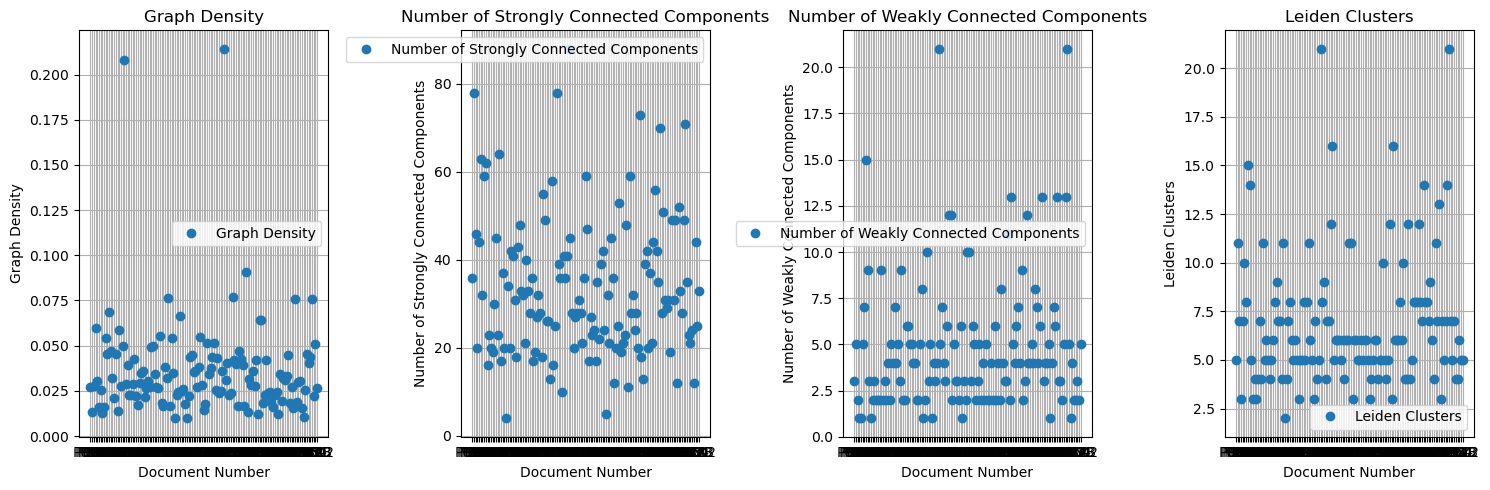

In [17]:
import matplotlib.pyplot as plt

# List of features to plot (columns from the DataFrame)
features = [
    'Graph Density', 
    'Number of Strongly Connected Components', 
    'Number of Weakly Connected Components',
    'Leiden Clusters'
]
df['Unnamed: 0'] = df.index
df.sort_values(by='Graph Density')
# Number of rows and columns for subplots
num_features = len(features)
num_columns = 4
num_rows = (num_features // num_columns) + (1 if num_features % num_columns != 0 else 0)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten axes for easier indexing if there are more than 1 row
axes = axes.flatten()
# Loop through each feature and create a plot
for idx, feature in enumerate(features):
    ax = axes[idx]
    
    # Plot the feature against 'doc number'
    ax.plot(df['Unnamed: 0'], df[feature], marker='o', linestyle=' ', label=feature)
    
    ax.set_title(f'{feature}')
    ax.set_xlabel('Document Number')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend()  # Add a legend for the feature being plotted

# Hide any unused axes if the number of features is not a perfect multiple of 3
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


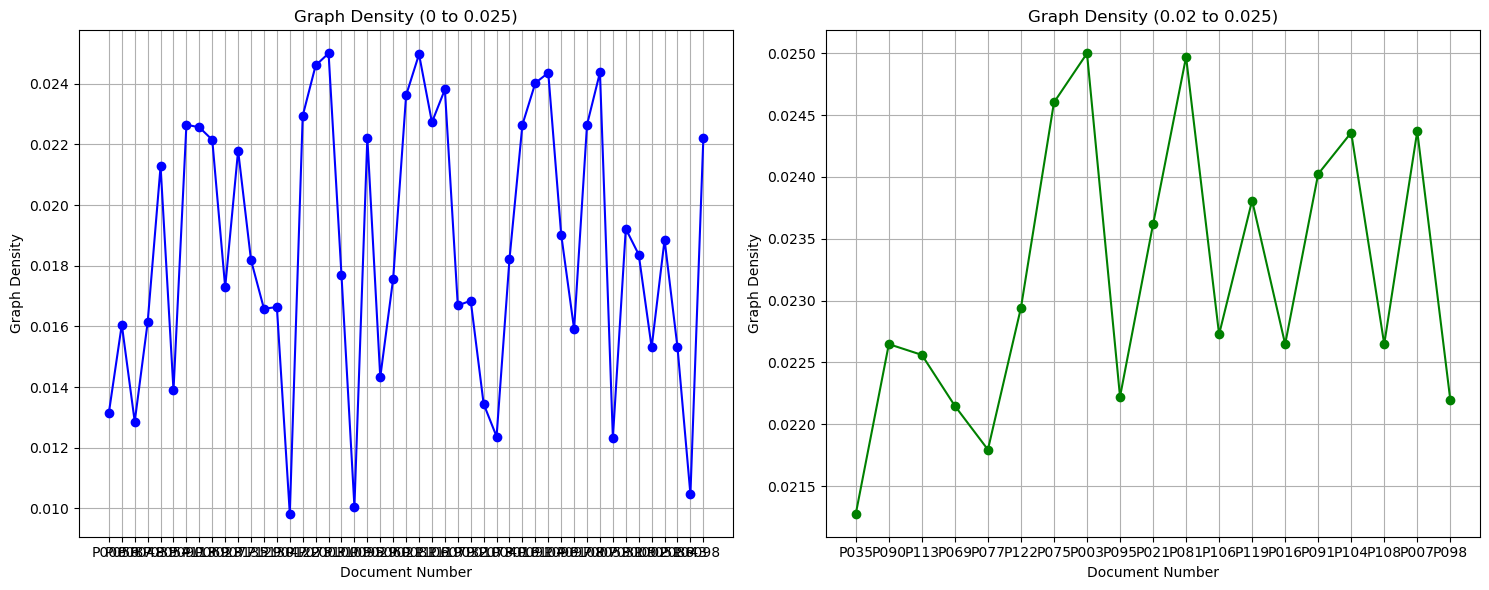

In [18]:
import matplotlib.pyplot as plt

# Filter DataFrame for the specified ranges
df_filtered_1 = df[(df['Graph Density'] > 0) & (df['Graph Density'] <= 0.025)]
df_filtered_2 = df[(df['Graph Density'] > 0.02) & (df['Graph Density'] <= 0.025)]

# Create subplots for the two graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Graph Density between 0 and 0.025
axes[0].plot(df_filtered_1['Unnamed: 0'], df_filtered_1['Graph Density'], marker='o', linestyle='-', color='blue')
axes[0].set_title('Graph Density (0 to 0.025)')
axes[0].set_xlabel('Document Number')
axes[0].set_ylabel('Graph Density')
axes[0].grid(True)

# Plot for Graph Density between 0.02 and 0.025
axes[1].plot(df_filtered_2['Unnamed: 0'], df_filtered_2['Graph Density'], marker='o', linestyle='-', color='green')
axes[1].set_title('Graph Density (0.02 to 0.025)')
axes[1].set_xlabel('Document Number')
axes[1].set_ylabel('Graph Density')
axes[1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [19]:
len(df_filtered_2)

19

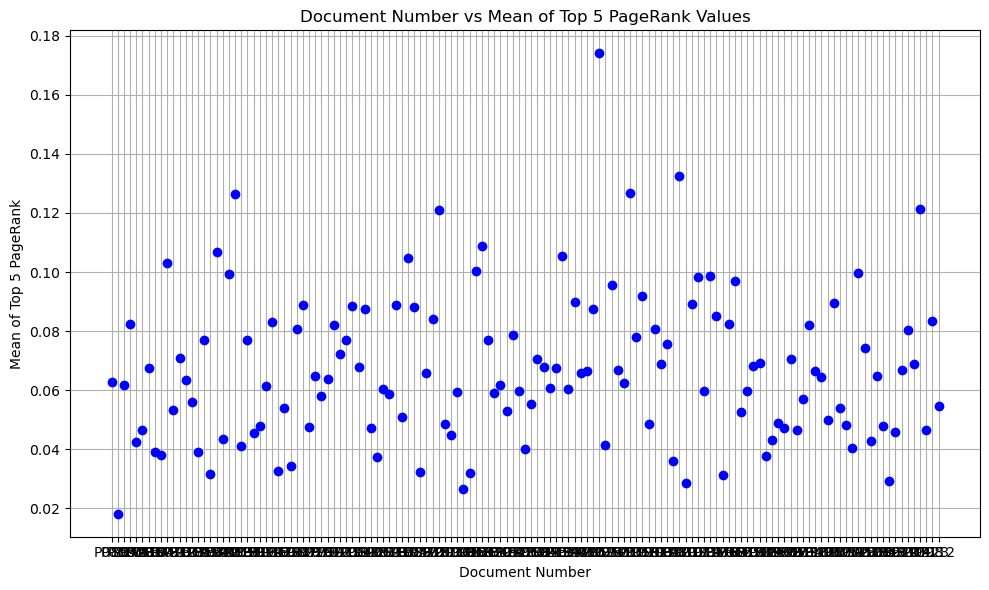

In [20]:
import pandas as pd
import ast

# Assuming the DataFrame is already loaded as 'df'
# Parse the PageRank column
#df['PageRank'] = df['PageRank'].apply(ast.literal_eval)  # Convert string to dictionary
import matplotlib.pyplot as plt

# Function to analyze a single document's PageRank
def analyze_document(doc_number, pagerank_dict):

    # Convert dictionary to a DataFrame
    doc_df = pd.DataFrame(list(pagerank_dict.items()), columns=['Node', 'PageRank'])

    # Sort by PageRank
    doc_df.sort_values(by='PageRank', ascending=False, inplace=True)


# Run analysis for each document
for idx, row in df.iterrows():
    analyze_document(row['Unnamed: 0'], row['PageRank'])
import matplotlib.pyplot as plt

# Function to calculate the mean of the top 5 PageRank values for a document
def calculate_top_5_mean(pagerank_dict):
    # Sort the PageRank values in descending order and select top 5
    top_5_values = sorted(pagerank_dict.values(), reverse=True)[:5]
    # Return the mean of the top 5 PageRank values
    return sum(top_5_values) / len(top_5_values)

# List to store the document numbers and corresponding mean of top 5 PageRank values
doc_numbers = []
mean_top_5_pageranks = []


# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    doc_number = row['Unnamed: 0']
    pagerank_dict = row['PageRank']

    # Calculate the mean of the top 5 PageRank values
    mean_top_5 = calculate_top_5_mean(pagerank_dict)

    # Append the document number and mean to the lists
    doc_numbers.append(doc_number)
    mean_top_5_pageranks.append(mean_top_5)

df['mean top 5 pr'] = mean_top_5_pageranks
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(doc_numbers, mean_top_5_pageranks, marker='o', linestyle=' ', color='b')
plt.title('Document Number vs Mean of Top 5 PageRank Values')
plt.xlabel('Document Number')
plt.ylabel('Mean of Top 5 PageRank')
plt.grid(True)
plt.xticks(doc_numbers)  # Set x-ticks to be the document numbers
plt.tight_layout()
plt.show()


In [33]:
# Create the 'Publishable' column
df['Publishable'] = (df['mean top 5 pr'] > 0.0562)
final_df = df[['Publishable']]

In [34]:
final_df.info

<bound method DataFrame.info of       Publishable
P085         True
P006        False
P127         True
P044         True
P008        False
...           ...
P004         True
P071         True
P098        False
P123         True
P112        False

[135 rows x 1 columns]>

In [35]:
final_df['Publishable'].sum()

86

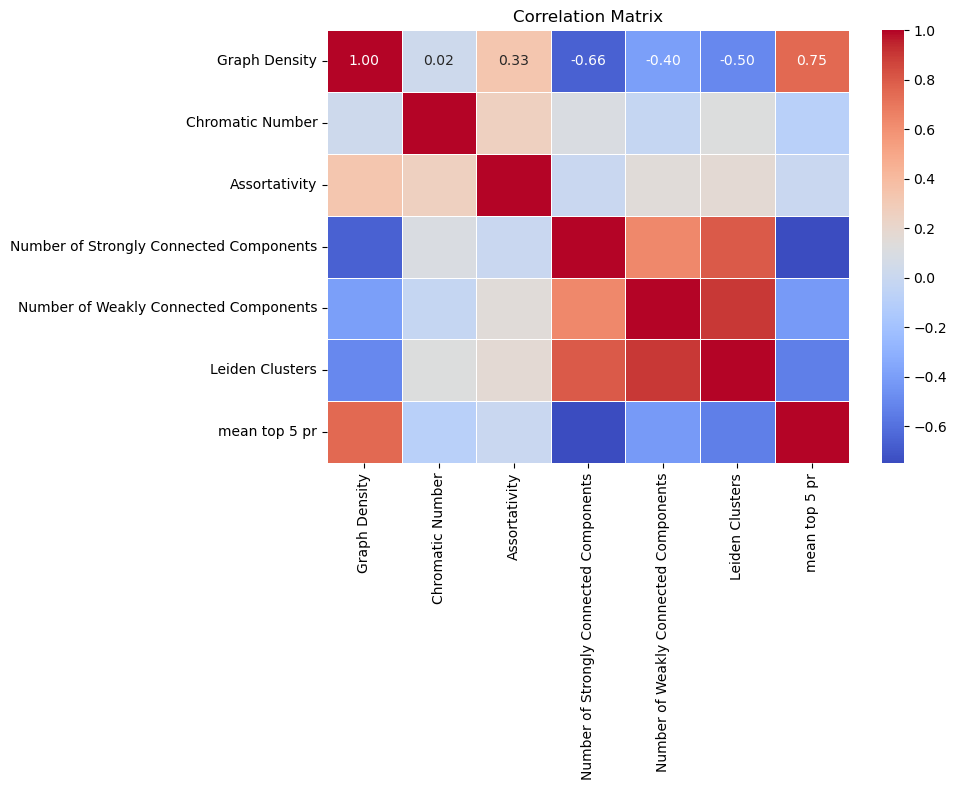

                                         Graph Density  Chromatic Number  \
Graph Density                                 1.000000          0.024873   
Chromatic Number                              0.024873          1.000000   
Assortativity                                 0.333803          0.255643   
Number of Strongly Connected Components      -0.663132          0.100078   
Number of Weakly Connected Components        -0.395047         -0.021742   
Leiden Clusters                              -0.500755          0.121745   
mean top 5 pr                                 0.750604         -0.091335   

                                         Assortativity  \
Graph Density                                 0.333803   
Chromatic Number                              0.255643   
Assortativity                                 1.000000   
Number of Strongly Connected Components      -0.000586   
Number of Weakly Connected Components         0.147086   
Leiden Clusters                            

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns from the DataFrame
df_numeric = df.select_dtypes(include=[float, int])

# Calculate the correlation matrix for the numeric columns
correlation_matrix = df_numeric.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Display the correlation matrix
print(correlation_matrix)


Mean of values between 0.05 and 0.06: 0.05622010416885927


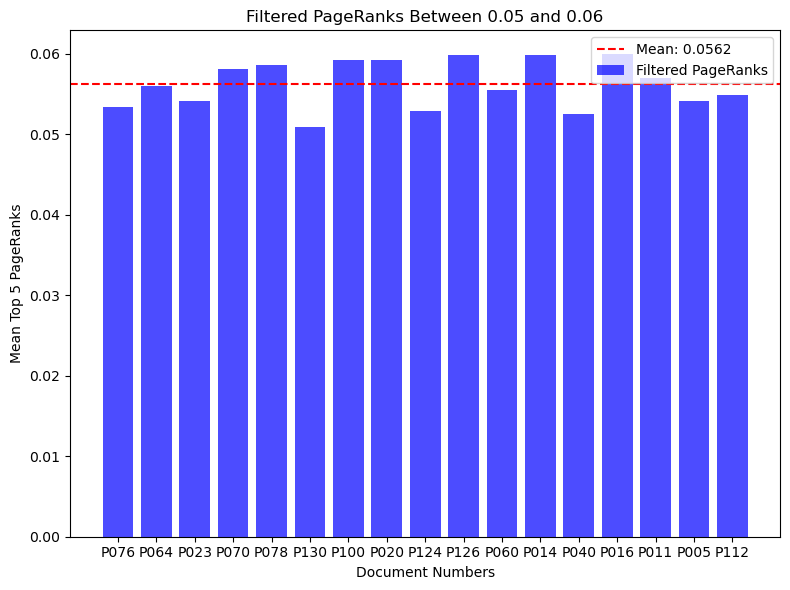

In [25]:
import numpy as np
# Filter values between 0.05 and 0.06
filtered_indices = [
    i for i, value in enumerate(mean_top_5_pageranks) 
    if 0.05 <= value <= 0.06
]
filtered_doc_numbers = [doc_numbers[i] for i in filtered_indices]
filtered_pageranks = [mean_top_5_pageranks[i] for i in filtered_indices]

# Calculate the mean
mean_value = sum(filtered_pageranks) / len(filtered_pageranks) if filtered_pageranks else None
print(f"Mean of values between 0.05 and 0.06: {mean_value}")

# Plot the filtered values
plt.figure(figsize=(8, 6))
plt.bar(filtered_doc_numbers, filtered_pageranks, color='blue', alpha=0.7, label='Filtered PageRanks')
if mean_value is not None:
    plt.axhline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.4f}')

# Adding labels and title
plt.xlabel('Document Numbers')
plt.ylabel('Mean Top 5 PageRanks')
plt.title('Filtered PageRanks Between 0.05 and 0.06')
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
len(filtered_doc_numbers)

17

In [57]:
filtered_doc_numbers

['P076',
 'P064',
 'P023',
 'P070',
 'P078',
 'P130',
 'P100',
 'P020',
 'P124',
 'P126',
 'P060',
 'P014',
 'P040',
 'P016',
 'P011',
 'P005',
 'P112']

In [58]:
df_filtered_2.index

Index(['P035', 'P090', 'P113', 'P069', 'P077', 'P122', 'P075', 'P003', 'P095',
       'P021', 'P081', 'P106', 'P119', 'P016', 'P091', 'P104', 'P108', 'P007',
       'P098'],
      dtype='object')

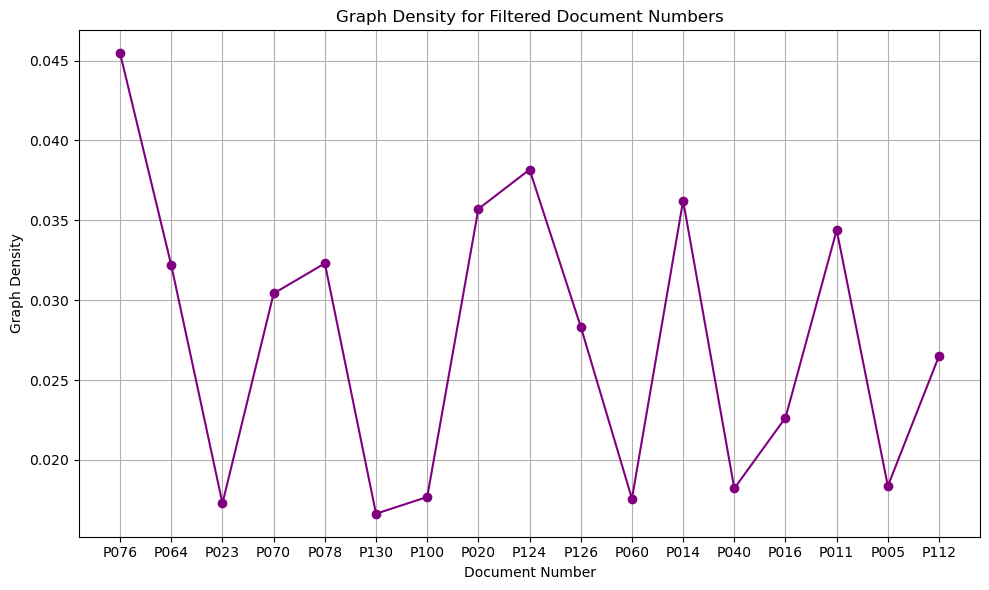

In [59]:

# Filter the DataFrame based on the filtered document numbers
df_filtered = df[df['Unnamed: 0'].isin(filtered_doc_numbers)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(
    df_filtered['Unnamed: 0'], 
    df_filtered['Graph Density'], 
    marker='o', 
    linestyle='-', 
    color='purple'
)

# Set title and labels
plt.title('Graph Density for Filtered Document Numbers')
plt.xlabel('Document Number')
plt.ylabel('Graph Density')

# Add grid for better visualization
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


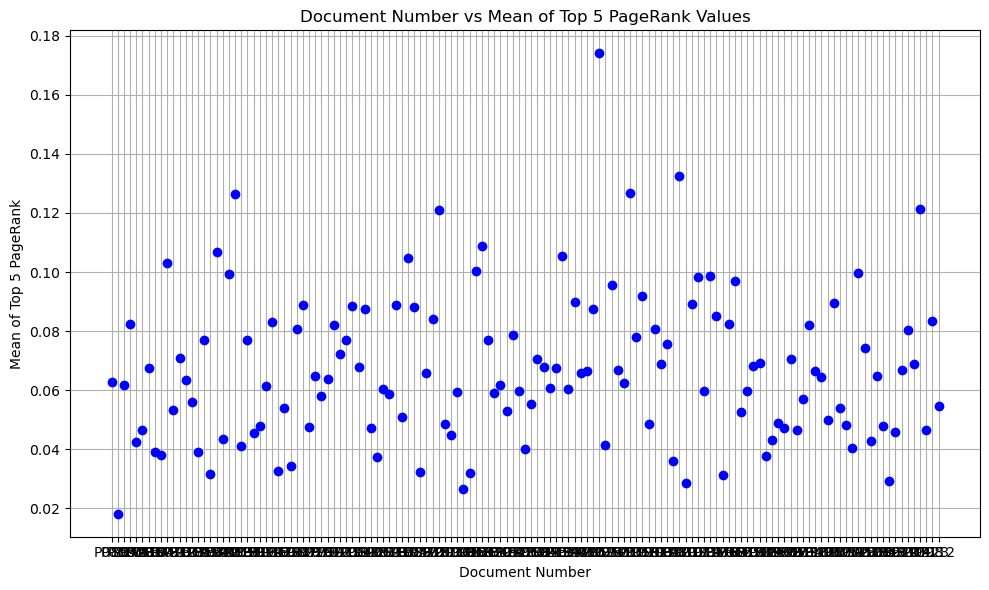

In [ ]:
import pandas as pd
import ast


df_fil = df[df['Unnamed: 0'].isin(df_filtered_1.index)]

# Assuming the DataFrame is already loaded as 'df'
# Parse the PageRank column
#df['PageRank'] = df['PageRank'].apply(ast.literal_eval)  # Convert string to dictionary
import matplotlib.pyplot as plt

# Function to analyze a single document's PageRank
def analyze_document(doc_number, pagerank_dict):

    # Convert dictionary to a DataFrame
    doc_df = pd.DataFrame(list(pagerank_dict.items()), columns=['Node', 'PageRank'])

    # Sort by PageRank
    doc_df.sort_values(by='PageRank', ascending=False, inplace=True)


# Run analysis for each document
for idx, row in df.iterrows():
    analyze_document(row['Unnamed: 0'], row['PageRank'])
import matplotlib.pyplot as plt

# Function to calculate the mean of the top 5 PageRank values for a document
def calculate_top_5_mean(pagerank_dict):
    # Sort the PageRank values in descending order and select top 5
    top_5_values = sorted(pagerank_dict.values(), reverse=True)[:5]
    # Return the mean of the top 5 PageRank values
    return sum(top_5_values) / len(top_5_values)

# List to store the document numbers and corresponding mean of top 5 PageRank values
doc_numbers = []
mean_top_5_pageranks = []

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    doc_number = row['Unnamed: 0']
    pagerank_dict = row['PageRank']

    # Calculate the mean of the top 5 PageRank values
    mean_top_5 = calculate_top_5_mean(pagerank_dict)

    # Append the document number and mean to the lists
    doc_numbers.append(doc_number)
    mean_top_5_pageranks.append(mean_top_5)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(doc_numbers, mean_top_5_pageranks, marker='o', linestyle=' ', color='b')
plt.title('Document Number vs Mean of Top 5 PageRank Values')
plt.xlabel('Document Number')
plt.ylabel('Mean of Top 5 PageRank')
plt.grid(True)
plt.xticks(doc_numbers)  # Set x-ticks to be the document numbers
plt.tight_layout()
plt.show()


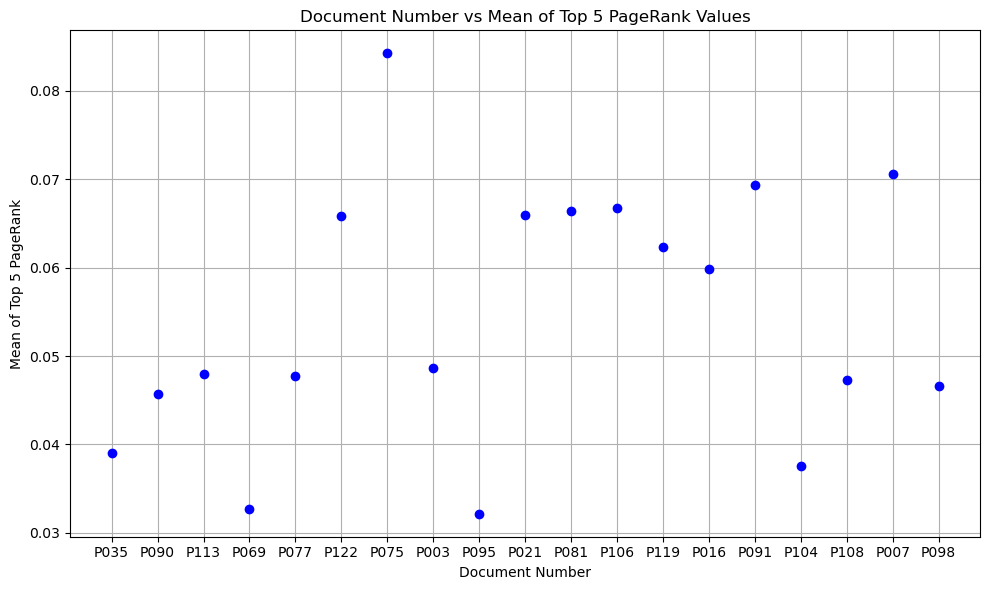

In [ ]:
import pandas as pd
import ast


df = df[df['Unnamed: 0'].isin(df_filtered_2.index)]

# Assuming the DataFrame is already loaded as 'df'
# Parse the PageRank column
#df['PageRank'] = df['PageRank'].apply(ast.literal_eval)  # Convert string to dictionary
import matplotlib.pyplot as plt

# Function to analyze a single document's PageRank
def analyze_document(doc_number, pagerank_dict):

    # Convert dictionary to a DataFrame
    doc_df = pd.DataFrame(list(pagerank_dict.items()), columns=['Node', 'PageRank'])

    # Sort by PageRank
    doc_df.sort_values(by='PageRank', ascending=False, inplace=True)


# Run analysis for each document
for idx, row in df.iterrows():
    analyze_document(row['Unnamed: 0'], row['PageRank'])
import matplotlib.pyplot as plt

# Function to calculate the mean of the top 5 PageRank values for a document
def calculate_top_5_mean(pagerank_dict):
    # Sort the PageRank values in descending order and select top 5
    top_5_values = sorted(pagerank_dict.values(), reverse=True)[:5]
    # Return the mean of the top 5 PageRank values
    return sum(top_5_values) / len(top_5_values)

# List to store the document numbers and corresponding mean of top 5 PageRank values
doc_numbers = []
mean_top_5_pageranks = []

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    doc_number = row['Unnamed: 0']
    pagerank_dict = row['PageRank']

    # Calculate the mean of the top 5 PageRank values
    mean_top_5 = calculate_top_5_mean(pagerank_dict)

    # Append the document number and mean to the lists
    doc_numbers.append(doc_number)
    mean_top_5_pageranks.append(mean_top_5)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(doc_numbers, mean_top_5_pageranks, marker='o', linestyle=' ', color='b')
plt.title('Document Number vs Mean of Top 5 PageRank Values')
plt.xlabel('Document Number')
plt.ylabel('Mean of Top 5 PageRank')
plt.grid(True)
plt.xticks(doc_numbers)  # Set x-ticks to be the document numbers
plt.tight_layout()
plt.show()


In [36]:
rel_df = pd.read_csv('graph_relationships_test_all.csv')
nan_columns = rel_df.columns[rel_df.isna().any()].tolist()

In [37]:
nan_columns

[]

In [38]:
nan_rows = rel_df[rel_df.isna().any(axis=1)]


In [39]:
nan_rows

,Unnamed: 0,Source,Target,Type,Paper ID


In [40]:
relationships_df

,Source,Target,Type,Paper ID
0,Tabular Synthetic Data,Privacy Evaluation,USED_FOR,P085
1,Synthetic Data,Privacy Protection,ENHANCES,P085
2,Synthetic Data,Analytic Utility,MAINTAINS,P085
3,Sd,Synthetic_Data,DEFINITION,P085
4,Synthetic_Data,Data_Science_Tasks,SOLUTION,P085
...,...,...,...,...
4310,Nutrition,Protein Synthesis,INFLUENCES,P048
4311,Strategy,Success,CONTRIBUTES_TO,P048
4312,Skill,Success,CONTRIBUTES_TO,P048
4313,Dark Matter Proteins,Protein Synthesis,IMPACTS,P048


In [45]:
import pandas as pd
import networkx as nx
import leidenalg
import igraph as ig

# Iterate over each unique "Paper ID" in the relationships dataframe
results = {}

for paper_id in relationships_df['Paper ID'].unique():
    # Filter the dataframe for the current Paper ID
    filtered_df = relationships_df[relationships_df['Paper ID'] == paper_id]
    
    # Step 1: Convert the filtered dataframe to a NetworkX graph
    G = nx.from_pandas_edgelist(
        filtered_df, 
        source='Source', 
        target='Target', 
        edge_attr='Type'
    )

    # Step 2: Convert to an iGraph graph for Leiden clustering
    igraph_graph = ig.Graph.TupleList(filtered_df.itertuples(index=False), directed=False)

    # Step 3: Apply the Leiden clustering algorithm
    partition = leidenalg.find_partition(igraph_graph, leidenalg.ModularityVertexPartition)

    # Step 4: Assign cluster labels to NetworkX graph nodes
    # Correctly handle cluster assignment
    clusters = {igraph_graph.vs[node]["name"]: cluster_id for cluster_id, cluster in enumerate(partition) for node in cluster}
    nx.set_node_attributes(G, clusters, 'cluster')

    # Step 5: Calculate centrality (e.g., degree centrality for simplicity)
    centrality = nx.degree_centrality(G)
    nx.set_node_attributes(G, centrality, 'centrality')
    
    # Step 6: Extract the top 2–3 nodes per cluster based on centrality
    paper_results = {}
    for cluster_id in set(clusters.values()):
        # Filter nodes in the current cluster
        nodes_in_cluster = [node for node in G.nodes if G.nodes[node].get('cluster') == cluster_id]
        # Sort nodes by centrality and select the top ones
        top_nodes = sorted(nodes_in_cluster, key=lambda x: G.nodes[x]['centrality'], reverse=True)[:3]
        paper_results[cluster_id] = {
            'Top Nodes': top_nodes,
            'Centrality': [G.nodes[node]['centrality'] for node in top_nodes]
        }
    
    # Store results for the current Paper ID
    results[paper_id] = paper_results

# Print results for all Paper IDs
for paper_id, clusters_info in results.items():
    print(f"Paper ID: {paper_id}")
    for cluster_id, info in clusters_info.items():
        print(f"  Cluster {cluster_id}:")
        print(f"    Top Nodes: {info['Top Nodes']}")
        print(f"    Centralities: {info['Centrality']}")


Paper ID: P085
  Cluster 0:
    Top Nodes: ['Synthetic Data', 'Gans', 'Vaes']
    Centralities: [0.3142857142857143, 0.05714285714285714, 0.05714285714285714]
  Cluster 1:
    Top Nodes: ['Sd', 'Synthetic_Data', 'Generator']
    Centralities: [0.08571428571428572, 0.08571428571428572, 0.08571428571428572]
  Cluster 2:
    Top Nodes: ['Database', 'Attribute', 'Data_Subject']
    Centralities: [0.14285714285714285, 0.08571428571428572, 0.02857142857142857]
  Cluster 3:
    Top Nodes: ['Data Memorization', 'Model And Data Properties', 'Improperly Trained Generators']
    Centralities: [0.17142857142857143, 0.05714285714285714, 0.02857142857142857]
  Cluster 4:
    Top Nodes: ['Privacy Evaluation', 'Tabular Synthetic Data', 'Standard']
    Centralities: [0.05714285714285714, 0.02857142857142857, 0.02857142857142857]
Paper ID: P006
  Cluster 0:
    Top Nodes: ['High-Throughput Genomic Sequencing', 'Marine Ecology', 'Marine Biology']
    Centralities: [0.33766233766233766, 0.0259740259740259

C:\Users\91934\AppData\Local\Temp\ipykernel_17228\1861044462.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


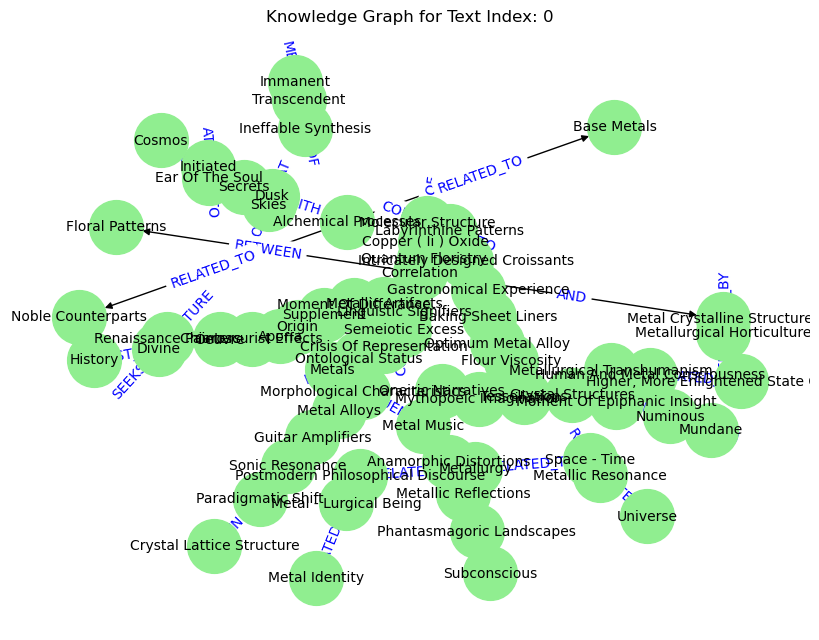

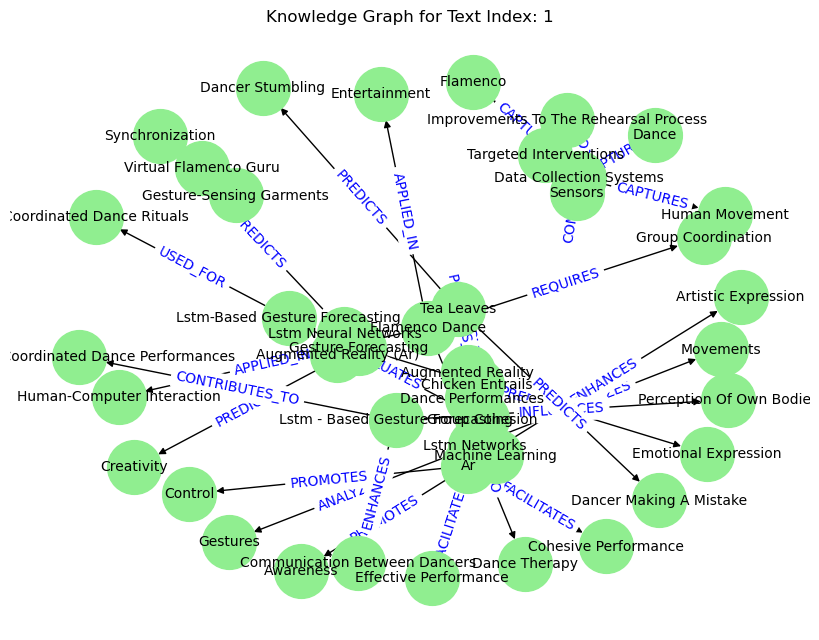

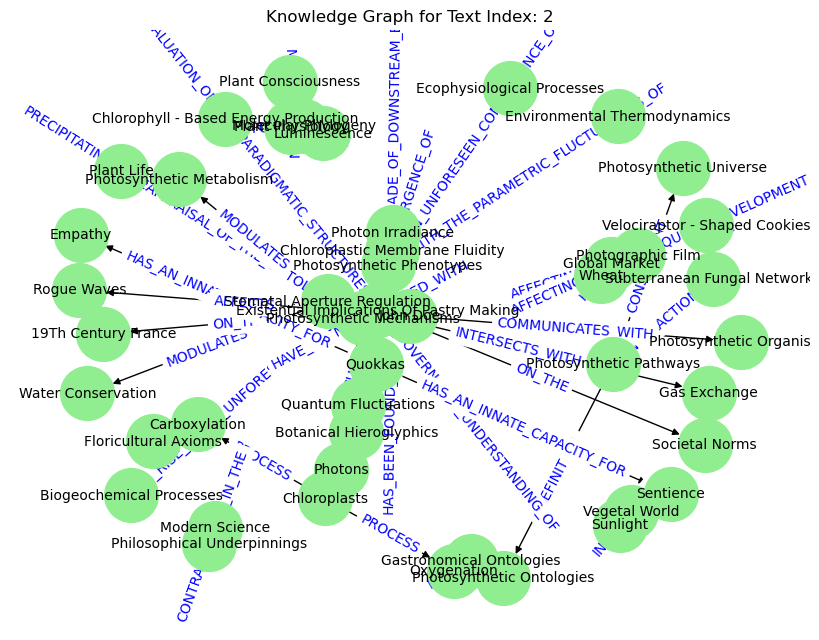

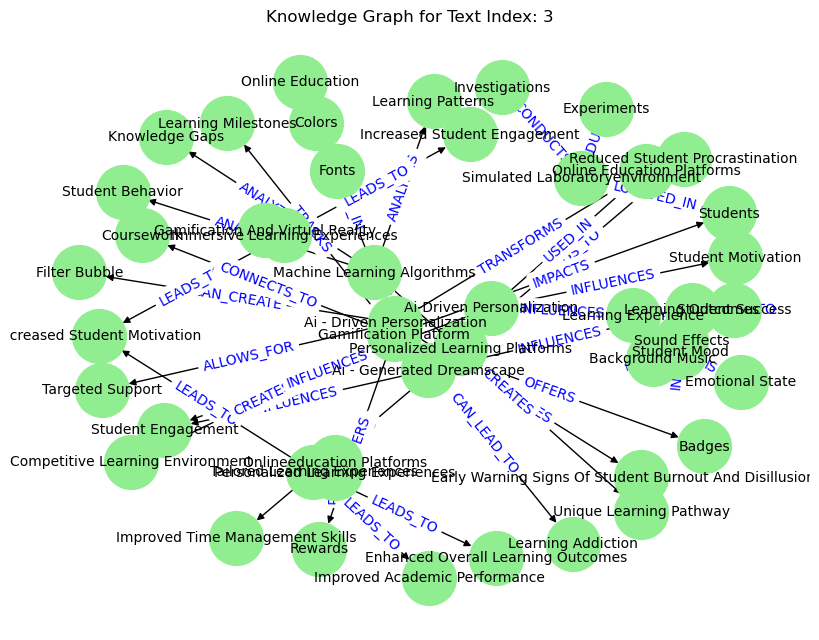

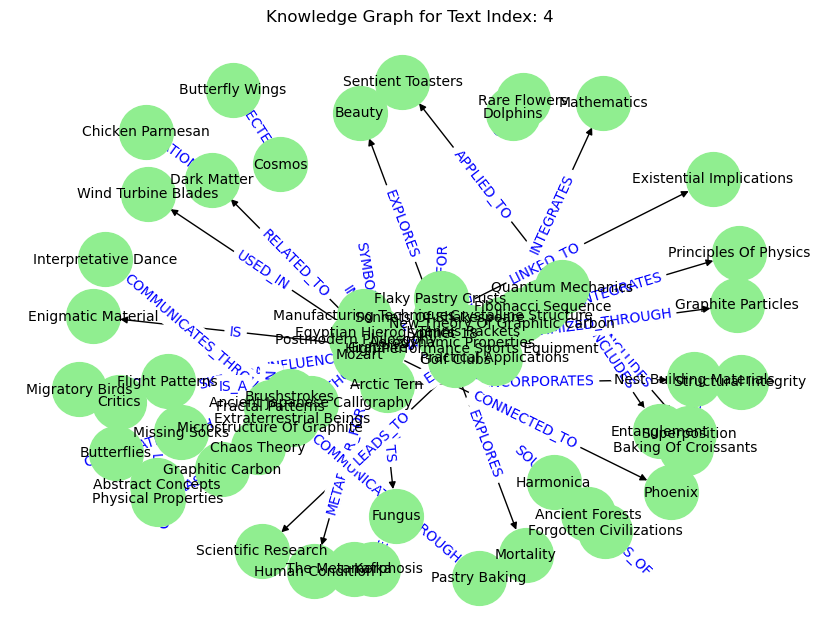

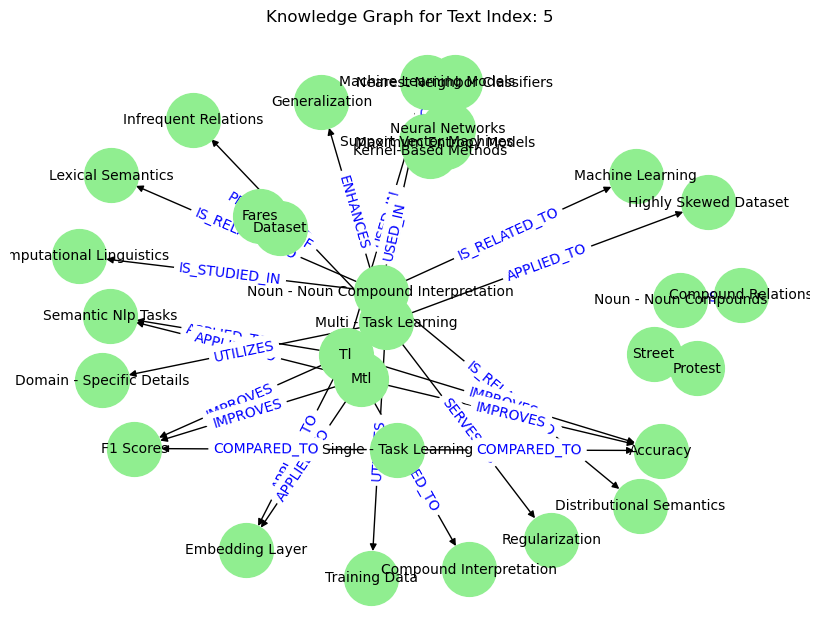

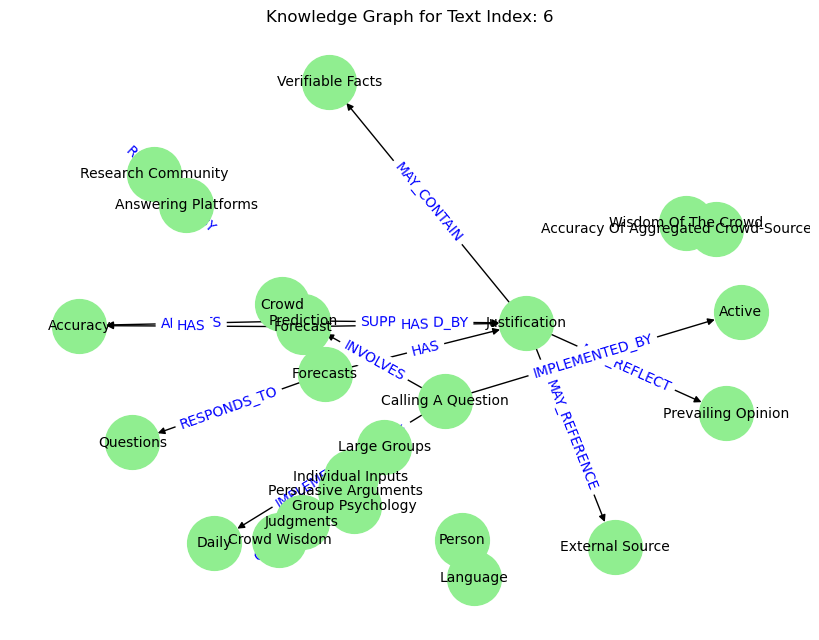

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("train data\graph_relationships_all_texts.csv")  # Replace with your file path
# Group the dataframe by 'Text Index'
grouped = df.groupby('Text Index')

for index, group in grouped:
    G = nx.DiGraph()

    # Add edges with relationship type as label
    for _, row in group.iterrows():
        G.add_edge(row['Source'], row['Target'], label=row['Type'])

    # Plotting
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, edge_color='black', font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')
    plt.title(f"Knowledge Graph for Text Index: {index}")
    plt.tight_layout()
    plt.show()


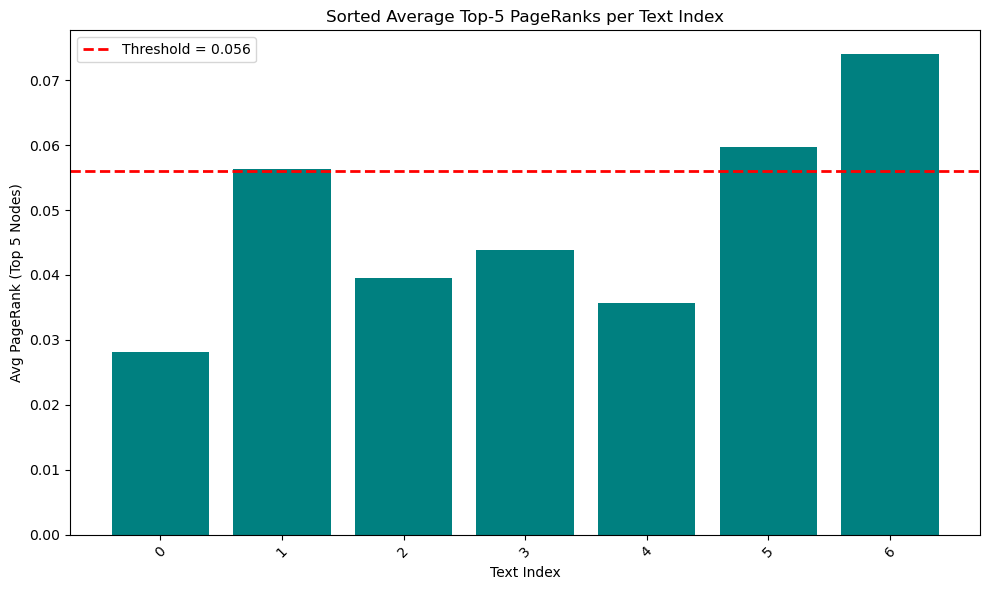

In [12]:
avg_top5_ranks = {}

for index, group in grouped:
    G = nx.DiGraph()

    # Add edges
    for _, row in group.iterrows():
        G.add_edge(row['Source'], row['Target'])

    if len(G) == 0:
        continue

    # Compute PageRank
    pagerank = nx.pagerank(G)

    # Take top 5 PageRank values
    top5_values = sorted(pagerank.values(), reverse=True)[:5]
    avg_top5 = sum(top5_values) / len(top5_values)
    
    avg_top5_ranks[index] = avg_top5

# Sort by average PageRank
sorted_avg = dict(sorted(avg_top5_ranks.items(), key=lambda item: item[1], reverse=True))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_avg.keys(), sorted_avg.values(), color='teal')
plt.axhline(y=0.056, color='red', linestyle='--', linewidth=2, label='Threshold = 0.056')

plt.xlabel("Text Index")
plt.ylabel("Avg PageRank (Top 5 Nodes)")
plt.title("Sorted Average Top-5 PageRanks per Text Index")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
